# Bone Age Prediction Model Training

This notebook implements a bone age prediction model using deep learning techniques. The model is trained on X-ray images using a combination of image preprocessing, feature extraction with a pre-trained VGG16 model, and regression to predict bone ages.

The notebook is structured as follows:
1. **Data Loading and Preprocessing**
2. **Model Building**
3. **Model Training and Evaluation**
4. **Prediction**
5. **Attention Map Visualization**


In [126]:
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import supervision as sv
from roboflow import Roboflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

Define paths to the datasets and load the CSV files containing image labels.


In [127]:
# Define the paths to the datasets
data_path = 'rsna-bone-age-dataset'
train_image_path = os.path.join(data_path, 'boneage-training-dataset')
test_image_path = os.path.join(data_path, 'boneage-test-dataset')

# Load the CSV files containing the labels
train_labels = pd.read_csv(os.path.join(data_path, 'boneage-training-dataset.csv'))
test_labels = pd.read_csv(os.path.join(data_path, 'boneage-test-dataset.csv'))

# Display the first few rows of the training and test datasets
print("Training Dataset:")
print(train_labels.head())
print("\nTest Dataset:")
print(test_labels.head())

# Initialize the Roboflow API
api_key = "It0WPkl2TkJgCXRF0PCh"
rf = Roboflow(api_key=api_key)
project = rf.workspace().project("x-ray-mask")
roboflow_model = project.version(1).model

Training Dataset:
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

Test Dataset:
   Case ID Sex
0     4360   M
1     4361   M
2     4362   M
3     4363   M
4     4364   M
loading Roboflow workspace...
loading Roboflow project...


### Image Preprocessing Functions

These functions preprocess the images before feeding them into the model:
- `preprocess_image`: Applies grayscale conversion, gamma correction, adaptive histogram equalization, and noise reduction.
- `extract_proi`: Extracts phalangeal regions of interest (PROI) using a pre-trained model and masks.
- `resize_image`: Resizes images to a fixed size while maintaining aspect ratio.


In [128]:
# Function to preprocess an image
def preprocess_image(image):
    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Gamma Correction 
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected_image = cv2.LUT(image, table)

    # Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(image)

    # Image Fusion
    fused_image = cv2.addWeighted(image, 0.5, gamma_corrected_image, 0.25, 0)
    fused_image = cv2.addWeighted(fused_image, 0.75, clahe_image, 0.25, 0)

    # Noise Reduction
    denoised_image = cv2.fastNlMeansDenoising(fused_image, None, 10, 7, 21)

    return denoised_image

# Function to extract phalangeal regions of interest (PROI) from an image
def extract_proi(image, img_path):
    # Perform inference on the image using the Roboflow model
    result = roboflow_model.predict(img_path, confidence=40).json()

    # Extract the detections from the result
    detections = sv.Detections.from_inference(result)

    # Filter the detections to only include the phalangeal regions of interest
    detections = detections[(detections.class_id == 0) | (detections.class_id == 6) | (detections.class_id == 7)]

    # Annotate the image with the detections
    mask_annotator = sv.MaskAnnotator()

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Annotate a mask with the detections
    mask = np.zeros_like(image)
    annotated_image = mask_annotator.annotate(scene=mask, detections=detections)

    # Extract the masked area from the image
    masked_image = np.where(annotated_image > 0, image, 0)

    # Convert to grayscale for finding contours
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # Find contours in the image
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute the bounding box of all the contours
    if len(contours) > 0:
        # Combine all the contours into one
        combined_contour = np.concatenate(contours)

        # Calculate the bounding box
        x, y, w, h = cv2.boundingRect(combined_contour)

        # Crop the image to the bounding box
        masked_image = masked_image[y:y+h, x:x+w]

    return masked_image

# Function to resize the image with a fixed aspect ratio
def resize_image(image, target_size=(256, 256)):
    # Resize the image with a fixed aspect ratio
    h, w = image.shape[:2]
    if h > w:
        new_h = target_size[0]
        new_w = int(w * new_h / h)
    else:
        new_w = target_size[1]
        new_h = int(h * new_w / w)

    resized_image = cv2.resize(image, (new_w, new_h))

    # Pad the image to the target size
    pad_h = (target_size[0] - new_h) // 2
    pad_w = (target_size[1] - new_w) // 2
    padded_image = cv2.copyMakeBorder(resized_image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    if padded_image.shape[:2] != target_size:
        padded_image = cv2.resize(padded_image, target_size)

    return padded_image


### Prepare the Training Dataset

Prepare the training dataset by iterating through the training labels, loading images, preprocessing, and extracting PROI.


In [129]:
# Prepare the training dataset
x_train = []
y_train = []

# Iterate over the training dataset
for index, row in train_labels.iterrows():
    img_path = os.path.join(train_image_path, str(row['id']) + '.png')
    image = cv2.imread(img_path)
    print(img_path)

    preprocessed_image = preprocess_image(image)
    proi = extract_proi(preprocessed_image, img_path) 
    proi = resize_image(proi)

    # Normalize the pixel values to the range [0, 1]
    proi = proi / 255.0
    
    # Append the features to the training dataset
    x_train.append(proi)
    # Append the bone age to the target dataset
    y_train.append(row['boneage'])

# Convert to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Split the training dataset into training and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

rsna-bone-age-dataset\boneage-training-dataset\1377.png
rsna-bone-age-dataset\boneage-training-dataset\1378.png
rsna-bone-age-dataset\boneage-training-dataset\1379.png
rsna-bone-age-dataset\boneage-training-dataset\1380.png
rsna-bone-age-dataset\boneage-training-dataset\1381.png
rsna-bone-age-dataset\boneage-training-dataset\1382.png
rsna-bone-age-dataset\boneage-training-dataset\1383.png
rsna-bone-age-dataset\boneage-training-dataset\1384.png
rsna-bone-age-dataset\boneage-training-dataset\1385.png
rsna-bone-age-dataset\boneage-training-dataset\1387.png
rsna-bone-age-dataset\boneage-training-dataset\1388.png
rsna-bone-age-dataset\boneage-training-dataset\1389.png
rsna-bone-age-dataset\boneage-training-dataset\1390.png
rsna-bone-age-dataset\boneage-training-dataset\1391.png
rsna-bone-age-dataset\boneage-training-dataset\1393.png
rsna-bone-age-dataset\boneage-training-dataset\1394.png
rsna-bone-age-dataset\boneage-training-dataset\1395.png
rsna-bone-age-dataset\boneage-training-dataset\1

MemoryError: Unable to allocate 18.5 GiB for an array with shape (12611, 256, 256, 3) and data type float64

## Build and Compile the Model

Build the bone age prediction model using a pre-trained VGG16 base with additional custom layers for regression.


In [ ]:
# Load the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

## Model Training and Evaluation

### Training

Train the model on the preprocessed training dataset with callbacks for early stopping and model checkpointing.


In [ ]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bone_age_model.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)


# Train the model
history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stopping, model_checkpoint]
    )

# Save the model
model.save('bone_age_model.keras')

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 13187.3594 - mean_absolute_error: 101.5106 - val_loss: 14294.1465 - val_mean_absolute_error: 109.5123
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 13905.7539 - mean_absolute_error: 105.9799 - val_loss: 14266.6797 - val_mean_absolute_error: 109.3871
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 14518.6885 - mean_absolute_error: 108.2077 - val_loss: 14238.9238 - val_mean_absolute_error: 109.2605
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 13830.6641 - mean_absolute_error: 105.4004 - val_loss: 14210.4766 - val_mean_absolute_error: 109.1312
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 13938.3799 - mean_absolute_error: 106.1587 - val_loss: 14181.0918 - val_mean_absolute_error: 108.9968
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 13506.4277 - mean_absolute_error: 103.3567 - val_loss: 14150.3184 - val_mean_absolute_error: 108.8543
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - lo

### Evaluation
Evaluate the trained model on the training set to assess performance.

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_train, y_train)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

## Prediction
Load the best saved model and use it to predict bone ages for the test dataset.


In [ ]:
# Load the model
model = load_model('bone_age_model.keras')

# Prepare the test dataset
x_test = []

# Iterate over the test dataset
for index, row in test_labels.iterrows():
    img_path = os.path.join(test_image_path, str(row['Case ID']) + '.png')
    image = cv2.imread(img_path)
    print(img_path)
    
    preprocessed_image = preprocess_image(image)
    proi = extract_proi(preprocessed_image, img_path)
    proi = resize_image(proi)

    # Normalize the pixel values to the range [0, 1]
    proi = proi / 255.0

    # Append the features to the test dataset
    x_test.append(proi)

# Convert to NumPy arrays
x_test = np.array(x_test)

# Predict the bone age
y_test = model.predict(x_test)

# Save the predictions to a CSV file
test_labels['Predicted Bone Age'] = y_test
test_labels.to_csv('predictions.csv', index=False)

# Display the first few rows of the predictions
print("Predictions:")
print(test_labels.head())

rsna-bone-age-dataset\boneage-test-dataset\4360.png
rsna-bone-age-dataset\boneage-test-dataset\4361.png
rsna-bone-age-dataset\boneage-test-dataset\4362.png


KeyboardInterrupt: 

## Attention Map Visualization

### Grad-CAM Heatmap
Visualize the regions of interest in the X-ray images that contribute most to the predictions using Grad-CAM.


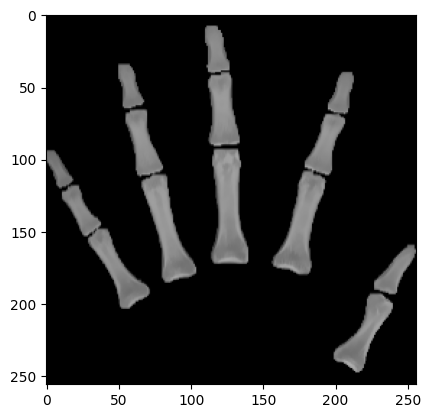

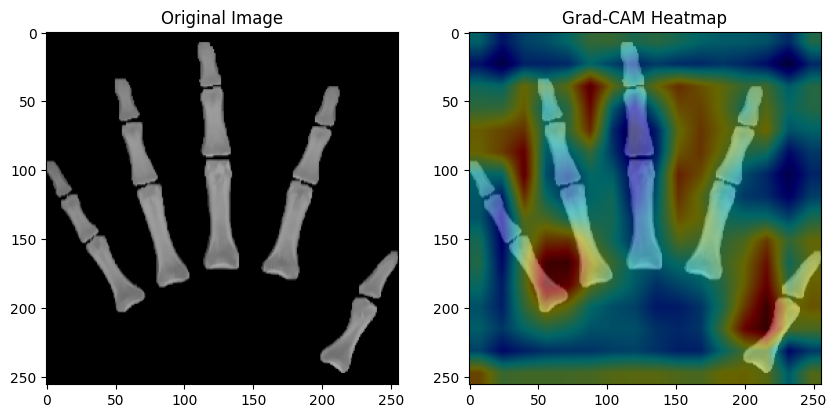

In [ ]:
# Function to compute the Grad-CAM heatmap
def compute_gradcam(model, img_array, layer_name):
    grad_model = Model(model.inputs, [model.get_layer(layer_name).output, model.output])
    
    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions

    # Extract the output and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    # Average the gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(output.shape[:2], dtype=np.float32)

    # Multiply the output feature map with the computed weights
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    heatmap = np.uint8(255 * heatmap)

    # Apply a colormap to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    return heatmap

# Function to overlay the heatmap on the image
def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = heatmap.astype(np.float32) / 255.0
    overlayed_image = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
    return overlayed_image

# Load the model
model = load_model('bone_age_model.keras')

img_path = 'rsna-bone-age-dataset/boneage-training-dataset/1377.png'
image = cv2.imread(img_path)

# Process the image and extract the phalangeal region of interest (PROI)
preprocessed_image = preprocess_image(image)
proi = extract_proi(preprocessed_image, img_path)
proi = resize_image(proi)

# Normalize the pixel values to the range [0, 1]
proi = proi.astype(np.float32) / 255.0

# Reshape for model input
img_array = np.expand_dims(proi, axis=0)

# Compute Grad-CAM
heatmap = compute_gradcam(model, img_array, 'block5_conv3')

# Overlay heatmap on the image
overlayed_image = overlay_heatmap(proi, heatmap)

# Display the original and overlayed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(proi, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.show()